Part 1

In [1]:
import os
import numpy as np
import scipy 
import random
import matplotlib.pyplot as plt
import IPython
import sounddevice as sd
import soundfile as sf

Step 1.0

In [2]:
music_stereo, f1 = sf.read('music.wav')
music_mono = music_stereo[:,0]/2 + music_stereo[:,1]/2 # Convert to mono format

music = music_mono / np.amax(abs(music_mono)) # Music normalized 

N = 512 # frame length
hann = np.hanning(N)
                             
size = np.size(music)
frames = []                             

i = 0 
while i <= (size - 512):
    frames.append(music[i:i+512]*hann)   # List of frames of 512 specimens windowed with hanning
    i = i + 512

Zeros = np.zeros(512 - (size - i)) # Zero-pad Last Frame to have 512 specimes 
frames.append(np.concatenate((music[i:], Zeros), axis = None)*hann)

Step 1.1

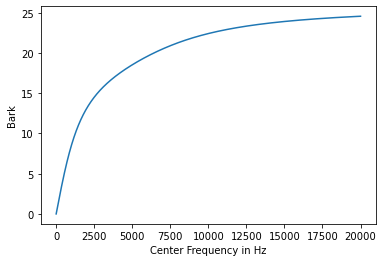

In [13]:
%matplotlib inline
f = np.arange(0,20000,1)
b = 13* np.arctan(0.00076*f) + 3.5*np.arctan((f/7500)**2) # bark scale

plt.figure(1)
plt.plot(f,b)
plt.xlabel('Center Frequency in Hz')
plt.ylabel('Bark')

Power_Spectrum = []
PN = 90.302

for frame in frames:
    p = 20*np.log10(abs(np.fft.fft(frame))) + PN
    p_cut = p[:256]
    Power_Spectrum.append(p_cut)



In [ ]:
#power spectrums as a function of bins

Text(0.5, 1.0, 'Power Spectrum of 3rd frame')

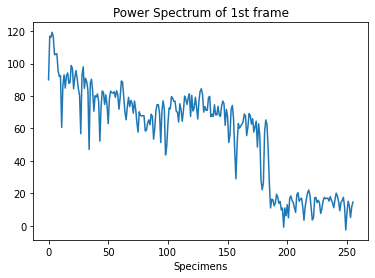

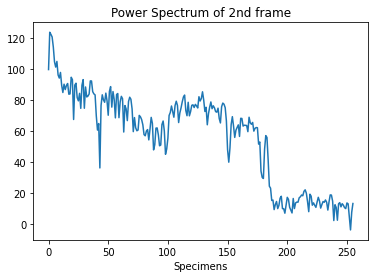

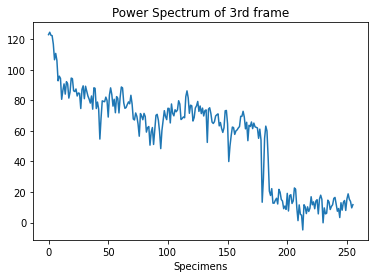

In [12]:
plt.figure(2)
k = np.arange(0,256,1)
plt.plot(k,Power_Spectrum[0])
plt.xlabel('Specimens')
plt.title('Power Spectrum of 1st frame')

plt.figure(3)
plt.plot(k,Power_Spectrum[1])
plt.xlabel('Specimens')
plt.title('Power Spectrum of 2nd frame')

plt.figure(4)
plt.plot(k,Power_Spectrum[2])
plt.xlabel('Specimens')
plt.title('Power Spectrum of 3rd frame')    

In [ ]:
#power spectrums as a function of barks

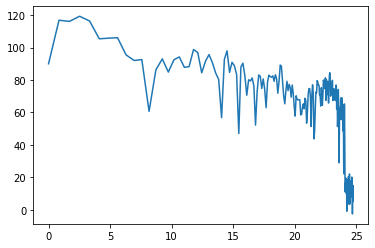

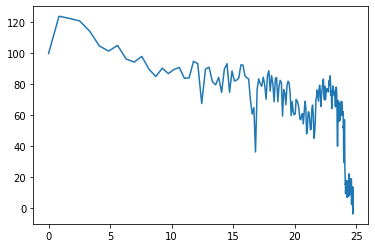

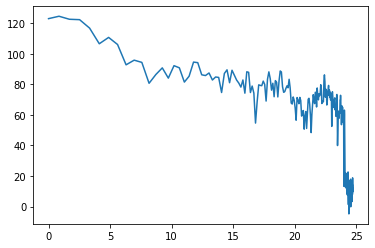

In [11]:
fs = 44100

i = np.arange(0,256,1)
f_new = i*fs/N
b_new = 13* np.arctan(0.00076*f_new) + 3.5*np.arctan((f_new/7500)**2) # bark scale

plt.figure(1)
plt.plot(b_new,Power_Spectrum[0])
plt.figure(2)
plt.plot(b_new,Power_Spectrum[1])
plt.figure(3)
plt.plot(b_new,Power_Spectrum[2])

Step 1.2

In [26]:
def St(k, power_spectrum):
    bool = True 
    i = 2
    if k <= 2:
        bool = False
    elif 2 < k < 63 :
        predicate_1 = power_spectrum[k] > power_spectrum[k - 1] and power_spectrum[k] > power_spectrum[k + 1]
        bool = predicate_1 and bool
        while i <= 2:
            predicate = power_spectrum[k] > (power_spectrum[k - i] + 7) and power_spectrum[k] > (power_spectrum[k + i] + 7)
            bool = predicate and bool
            i = i + 1
    elif 63 <= k < 127 :
        predicate_1 = power_spectrum[k] > power_spectrum[k - 1] and power_spectrum[k] > power_spectrum[k + 1]
        bool = predicate_1 and bool
        while i <= 3:
            predicate = power_spectrum[k] > (power_spectrum[k - i] + 7) and power_spectrum[k] > (power_spectrum[k + i] + 7)
            bool = predicate and bool
            i = i + 1
    elif 127 <= k <= 250 :
        predicate_1 = power_spectrum[k] > power_spectrum[k - 1] and power_spectrum[k] > power_spectrum[k + 1]
        bool = predicate_1 and bool
        while i <= 6:
            predicate = power_spectrum[k] > (power_spectrum[k - i] + 7) and power_spectrum[k] > (power_spectrum[k + i] + 7)
            bool = predicate and bool
            i = i + 1
    return bool

Tone_Masks = []
for power_spectrum in Power_Spectrum:
    Tone_Masks.append(np.zeros(256))
    for k in range(250):
        if(St(k, power_spectrum)):
            Tone_Masks[-1][k] = 10*np.log10(10**(0.1*power_spectrum[k-1]) + 10**(0.1*power_spectrum[k]) + 10**(0.1*power_spectrum[k+1]))


Tone_Masks = np.transpose(Tone_Masks)        # <--------------------------------
Noise_Masks = np.load('P_NM.npy')
#print(Noise_masks)

In [27]:
print(np.shape(Tone_Masks))
print(np.shape(Noise_Masks))

(256, 1179)
(256, 1179)


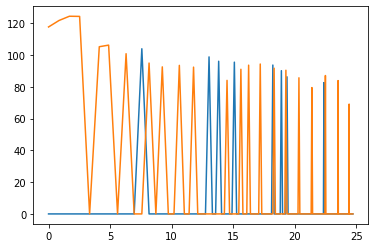

In [35]:
#printing the Tone & Noise Masks for random frame (e.g. 50th frame)

fs = 44100
N = 512

j = np.arange(0,256,1)
f_j = j*fs/N
b_j = 13* np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale

plt.plot(b_j, Tone_Masks[:,49])
plt.plot(b_j, Noise_Masks[:,49])

Step 1.3

In [22]:
tone_masks_cut = np.load('P_TMc.npy')
noise_masks_cut = np.load('P_NMc.npy')

In [24]:
print(np.shape(tone_masks_cut))

(256, 1179)


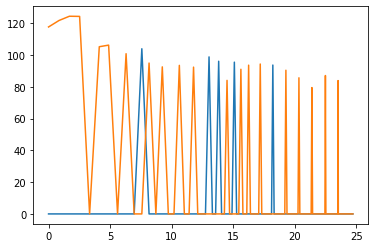

In [40]:
#printing the (now reduced) Tone & Noise Masks for the same frame as before

fs = 44100
N = 512

j = np.arange(0,256,1)
f_j = j*fs/N
b_j = 13* np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale

plt.plot(b_j, tone_masks_cut[:,49])
plt.plot(b_j, noise_masks_cut[:,49])


Step 1.4

In [41]:
fs = 44100

def SF(i, j, half_frame): #we assume (b_i - b_j) belongs to the set [-3,8)
    f_i = i*fs/N;
    f_j = j*fs/N;
    b_i = 13*np.arctan(0.00076*f_i) + 3.5*np.arctan((f_i/7500)**2) # bark scale
    b_j = 13*np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale
    delta = b_i - b_j
    if(delta>=-3 and delta<-1): return (17*delta - 0.4*half_frame[j] + 11)
    elif(delta<0): return ((0.4*half_frame[j] + 6)*delta)
    elif(delta<1): return -17*delta
    else: return ((0.15*half_frame[j] - 17)*delta - 0.15*half_frame[j])

def T_tm(i,j, half_frame):
    f_i = i*fs/N;
    f_j = j*fs/N;
    b_i = 13* np.arctan(0.00076*f_i) + 3.5*np.arctan((f_i/7500)**2) # bark scale
    b_j = 13* np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale
    delta = b_i - b_j
    if(delta<-3 or delta>=8): return 0
    else: return (half_frame[j] - 0.175*b_j + SF(i,j,half_frame) - 6.025)
    
def T_nm(i,j, half_frame):
    f_i = i*fs/N;
    f_j = j*fs/N;
    b_i = 13* np.arctan(0.00076*f_i) + 3.5*np.arctan((f_i/7500)**2) # bark scale
    b_j = 13* np.arctan(0.00076*f_j) + 3.5*np.arctan((f_j/7500)**2) # bark scale
    delta = b_i - b_j
    if(delta<-3 or delta>=8): return 0
    else: return (half_frame[j] - 0.175*b_j + SF(i,j,half_frame) - 2.025)
    

Individual_Masking_Thresholds = []
for counter in range(1179):
    half_frame_tone = tone_masks_cut[:,counter]
    half_frame_noise = noise_masks_cut[:,counter]
    j_noise = []
    j_tone = []
    Thresholds_per_half_frame = np.zeros((256,256), dtype=object) #we initialize a 2D array in which we want to store tuples
    for j in range(256):
        if(half_frame_tone[j]>0):
            j_tone.append(j)
        if(half_frame_noise[j]>0):
            j_noise.append(j)
    for j in j_noise:
        for i in range(256):
            T_noise = T_nm(i,j,half_frame_noise)
            Thresholds_per_half_frame[i][j] = (T_noise, 0)
    for j in j_tone:
        for i in range(256):
            T_tone = T_tm(i,j,half_frame_tone)
            if((isinstance(Thresholds_per_half_frame[i][j], int)==0)): Thresholds_per_half_frame[i][j] = (Thresholds_per_half_frame[i][j][0], T_tone)
            else: Thresholds_per_half_frame[i][j] = (0, T_tone)
    Individual_Masking_Thresholds.append(Thresholds_per_half_frame)
            

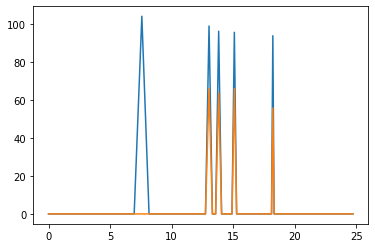

In [47]:
#printing tone masks alongside their thresholds, i=50

lista = []
for j in range(256):
    if((isinstance(Individual_Masking_Thresholds[49][49][j], int)==0)): lista.append(Individual_Masking_Thresholds[49][49][j][1])
    else: lista.append(0)
plt.plot(b_j, tone_masks_cut[:,49])
plt.plot(b_j,lista)



Step 1.5

In [50]:
fs = 44100
N = 512

def T_q(i):   
    f = i*fs/N;
    return 3.64*((f/1000)**(-0.8)) - 6.5*np.exp(-0.6*((f/1000 - 3.3)**2)) + (10**(-3))*((f/1000)**4)

In [51]:
def T_g(i, pinakas):
    sum_tone = 0
    sum_noise = 0
    for j in range(256):
        if((isinstance(pinakas[i][j], int)==0)):
            T_noise = pinakas[i][j][0]
            T_tone = pinakas[i][j][1]
            if(T_noise>0): sum_noise += 10**(0.1*T_noise)
            if(T_tone>0): sum_tone += 10**(0.1*T_tone)
    return 10*np.log10(10**(0.1*T_q(i)) + sum_noise + sum_tone)
            

In [52]:
Global_Masking_Thresholds = []

for counter in range(1179):
    Thresholds_list = []
    pinakas = Individual_Masking_Thresholds[counter]
    i = 1                
    while(i<256):
        total = T_g(i, pinakas)
        Thresholds_list.append(total)
        i += 1
    Global_Masking_Thresholds.append(Thresholds_list)


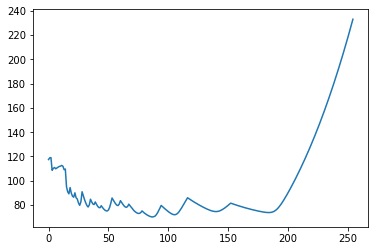

In [53]:
plt.plot(Global_Masking_Thresholds[0])

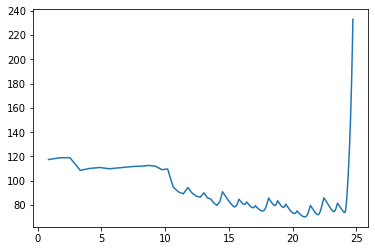

In [59]:
#plotting global masking thresholds as a function of barks

i = np.arange(1,256,1)
f_new = i*fs/N
b_new = 13* np.arctan(0.00076*f_new) + 3.5*np.arctan((f_new/7500)**2) # bark scale

plt.plot(b_new,(Global_Masking_Thresholds[0]))

Part 2

Step 2.0

In [35]:
H_Filters = []
G_Filters = []

M = 32
L = 2*M
n = np.arange(0,L,1)

for k in range(M):
    H_Filters.append(np.sin((n+1/2)*np.pi/(2*M))*np.sqrt(2/M)*np.cos((2*n+M+1)*(2*k+1)*np.pi/(4*M)))
    n1 = 2*M - 1 - n
    G_Filters.append(np.sin((n1+1/2)*np.pi/(2*M))*np.sqrt(2/M)*np.cos((2*n1+M+1)*(2*k+1)*np.pi/(4*M)))
    
#print(H_Filters[0])

In [36]:
time_compon = []

music = music_mono / np.amax(abs(music_mono)) # Music normalized 

N = 512 # frame length
                             
size = np.size(music)
frames = []                             

i = 0 
while i <= (size - 512):
    frames.append(music[i:i+512])   # List of frames of 512 specimens
    i = i + 512

Zeros = np.zeros(512 - (size - i)) # Zero-pad Last Frame to have 512 specimens 
frames.append(np.concatenate((music[i:], Zeros), axis = None))


for k in range(M):
    frames_processed = []
    for frame in frames:
        u = np.convolve(frame, H_Filters[k],'full')
        # y = scipy.signal.decimate(u,M)
        y = u[:-M:M]
        frames_processed.append(y)
    time_compon.append(frames_processed)


Step 2.2

In [37]:
fs = 44100
N = 512

B = 16
R = 2**B
Bits = []

k = 1
while k <= 32:
    indexes = []
    fk = (2*k - 1)*fs*np.pi/(2*M)
    r = fs*np.pi/(2*M)
    i = 1
    while i < 256:
        f = i*(2*np.pi/N)*fs
        if  (fk - r <= f) and (f <= fk + r): 
            indexes.append(i - 1)             # indexes corresponding to filter passband
        i = i + 1
    b = []
    for frame in range(1179):
        Tg = min([Global_Masking_Thresholds[frame][j] for j in indexes]) # min Global masking threshold
        b.append(int(np.ceil((np.log2(R/Tg) - 1))))
    Bits.append(b)
    k = k + 1  


In [42]:
#print(np.shape(Bits))

(32, 1179)
